In [1]:
# - compatibility with Python 3
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0

In [2]:
# - show figures inside the notebook
%matplotlib inline

In [3]:
# - import common modules
import numpy as np  # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

## The task time-course

We've previously had a look at the file `ds114_sub009_t2r1.nii`.  This is a 4D FMRI image.

Now we want to see whether we can detect any signal in that image relating to the task.

The task was a block design with 10 seconds rest followed by 7 repeats of (30 seconds when the subject thought of verbs followed by 30 seconds rest).  This is called a "covert" task, because the subjects were thinking of verbs instead of saying them.

There's a file in this directory called `ds114_sub009_t2r1_cond.txt` with the task information in it.   It comes from subject 9 task 2 and run 1 from OpenFMRI dataset https://openfmri.org/dataset/ds000114 .

The file has one line of text per "on" block, giving the onset time of the
block (in seconds), the duration of the block (in seconds) and the amplitude (expected amount of activation for this block - not used in this case).

Here are the first four lines:

```
10	30.000000	1
70	30.000000	1
130	30.000000	1
190	30.000000	1
```

In [4]:
# Read the file into an array called "task".
# "task" should have 3 columns (onset, duration, amplitude)
# HINT: np.loadtxt
task = np.loadtxt('ds114_sub009_t2r1_cond.txt')
task.shape

(7, 3)

The repitition time (time to repeat, TR) for this FMRI run was 2.5 seconds.  We need to convert the onsets and durations to TRs - so for example the first onset was at 10 seconds, which was the start of TR 4 (10 / 2.5).

Select out the first two columns of task, and divide by the TR to convert the onset and duration times to be in terms of TRs instead of seconds:

In [5]:
# Select first two columns and divide by TR
ons_durs = task[:, :2] / 2.5
ons_durs

array([[   4.,   12.],
       [  28.,   12.],
       [  52.,   12.],
       [  76.,   12.],
       [ 100.,   12.],
       [ 124.,   12.],
       [ 148.,   12.]])

Our next step is to make an on-off vector that is 0 when the subject is doing nothing and 1 when the subject is doing the covert verb task.

The vector will have one value (either 0 or 1) for each TR.

First use nibabel to load the image `ds114_sub009_t2r1.nii`.  Check the image shape to find the number of TRs.

In [6]:
# Load the image and check the image shape to get the number of TRs
import nibabel as nib
img = nib.load('ds114_sub009_t2r1.nii')
img.shape

(64, 64, 30, 173)

Next make a new vector called `time_course` with one entry per TR, with all elements in the vector being zero:

In [7]:
# Make new zero vector
time_course = np.zeros(img.shape[-1])

Loop over the rows in the onsets / durations array to give you an onset / duration pair.  For each of these pairs, set the matching positions in the `time_course` vector to 1.  For example, the first pair will be `4, 12`.   That means the task started at the beginning of scan index 4, and lasted for 12 scans.  That means there should be 12 consecutive 1 values in `time_course`, starting at index 4.  That means that index 4 + 12 = 16 should be zero again, because there are 12 values starting at (including 4) going up to (but *not* including) 16.

In [8]:
# - try running this if you don't believe me
len(range(4, 16))

12

So, for the first row, you will want to set `time_course[4]` through `time_course[15]` equal to 1.

In [9]:
# Fill in values of 1 for positions of on blocks in time course
for onset, duration in ons_durs:
    time_course[onset:onset + duration] = 1

Plot the time course:

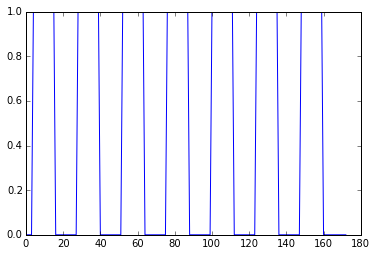

In [10]:
# Plot the time course
plt.plot(time_course)

## Comparing task to rest

Make a boolean array `is_task_tr` which is True when `time_course` is 1 and False otherwise.

Make another array `is_rest_tr` that is the opposite - True when `time_course` is 0 and False otherwise.

In [11]:
# Make two boolean arrays encoding task, rest
is_task_tr = (time_course == 1)
is_rest_tr = (time_course == 0)

Now read the image data into an array:

In [12]:
# Read the image data into an array.
data = img.get_data()

Remember that the 4D array consists of one volume (3D array) per TR.

We want to select the volumes where the time course is 1 (task volumes). Do this by slicing, using the boolean array you just made.

In [13]:
# Create a new 4D array only containing the task volumes
on_volumes = data[..., is_task_tr]

Now select the volumes where the time course is 0 (rest volumes):

In [14]:
# Create a new 4D array only containing the rest volumes
off_volumes = data[..., is_rest_tr]

We want to know whether there is a difference in signal in the task volumes compared to the rest volumes.  Take the mean over the task volumes and mean over the rest volumes.  You should end up with two 3D volumes.

In [15]:
# Create the mean volume across all the task volumes
# Then create the mean volume across all the rest volumes
# Hint: remember the `axis` keyword.
on_mean = on_volumes.mean(axis=-1)
off_mean = off_volumes.mean(axis=-1)

Now subtract the rest mean from the task mean to get a difference volume.

In [16]:
# Create a difference volume
difference = on_mean - off_mean

Show a slice over the third dimension of the difference volume, from somewhere around the center of the third axis:

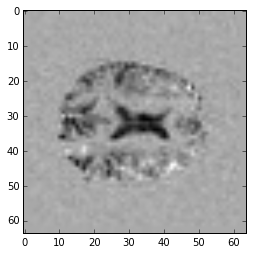

In [17]:
# Show a slice over the third dimension
plt.imshow(difference[:, :, 14], cmap='gray')

This is the difference between activation and rest.  It looks a little strange.  Maybe there are some artefacts here.

## Fixing the artefact

In the last exercise, you looked at this same 4D image to find volumes with unusually high variance / standard deviation.

There is one volume in this 4D image with particularly high standard deviation.

In fact, the bad volume is one of the rest volumes.

Use your slicing skills to remove this volume from your selection of rest volumes.

In [18]:
# Use slicing to remove outlier volume from rest volumes
off_volumes_fixed = off_volumes[..., 1:]

Make a new mean for the rest volumes, and subtract this mean from the mean for the task volumes to make a new difference image.

Give the new difference image a new name, so we can compare to the old difference image later.

In [19]:
# Make new mean for rest volumes, subtract from task mean
off_mean_fixed = off_volumes_fixed.mean(axis=-1)
difference_fixed = on_mean - off_mean_fixed

Show an example slice from the new difference volume.  Show the same slice from the old difference volume, using matplotlib.

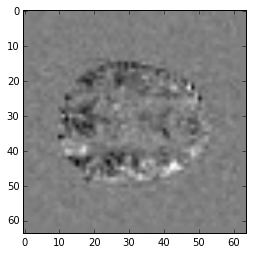

In [20]:
# show same slice from old and new difference volume
plt.imshow(difference_fixed[:, :, 14], cmap='gray')